# **How to Explain a Text Classifier**

In [56]:
import pandas as pd
pd.set_option('display.max_colwidth', 50)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.pipeline import make_pipeline

from lime.lime_text import LimeTextExplainer
from lime import submodular_pick
import eli5

In [2]:
# Cleaning up the data to remove special characters - will re-use the blueprint from Chapter 5
import html 
import re
# tags like 
RE_TAG = re.compile(r'<[^<>]*>')
# text or code in brackets like [0]
RE_BRACKET = re.compile('\[[^\[\]]*\]')
# text or code in brackets like (0)
RE_BRACKET_1 = re.compile('\([^)]*\)')
# specials that are not part of words; matches # but not #cool
RE_SPECIAL = re.compile(r'(?:^|\s)[&#<>{}\[\]+]+(?:\s|$)')
# standalone sequences of hyphens like --- or ==
RE_HYPHEN_SEQ = re.compile(r'(?:^|\s)[\-=\+]{2,}(?:\s|$)')
# sequences of white spaces
RE_MULTI_SPACE = re.compile('\s+')

def clean(text):
    text = html.unescape(text)
    text = RE_TAG.sub(' ', text)
    text = RE_BRACKET.sub(' ', text)
    text = RE_BRACKET_1.sub(' ', text)
    text = RE_SPECIAL.sub(' ', text)
    text = RE_HYPHEN_SEQ.sub(' ', text)
    text = RE_MULTI_SPACE.sub(' ', text)
    return text.strip()

## 1. **Determining Classification Confidence using Prediction Probability**

In [3]:
# Loading the dataframe

df = pd.read_csv('eclipse_jdt.csv.gz')
df = df.groupby('Component', as_index=False).apply(pd.DataFrame.sample, random_state=42, frac=.2)
df = df[['Title','Description','Component']]
df = df.dropna()
df['text'] = df['Title'] + " " + df['Description']
df = df.drop(columns=['Title','Description'])

# Step 1 - Data Preparation

df['text'] = df['text'].apply(clean)

# Step 2 - Train-Test Split

X_train, X_test, Y_train, Y_test = train_test_split(df['text'], df['Component'], 
                                                    test_size=0.2, random_state=42,
                                                    stratify=df['Component'])
print ('Size of Training Data ', X_train.shape[0])
print ('Size of Test Data ', X_test.shape[0])

# Step 3 - Training the Machine Learning model

tfidf = TfidfVectorizer(min_df = 10, ngram_range=(1,2), stop_words="english")
X_train_tf = tfidf.fit_transform(X_train)


svc = SVC(kernel="linear", C=1, probability=True, random_state=42)
svc.fit(X_train_tf, Y_train)

Size of Training Data  7240
Size of Test Data  1811


SVC(C=1, kernel='linear', probability=True, random_state=42)

In [4]:
X_test_tf = tfidf.transform(X_test)
Y_pred = svc.predict(X_test_tf)
result = pd.DataFrame({ 'text': X_test.values, 'actual': Y_test.values, 'predicted': Y_pred })

In [5]:
result[result["actual"] != result["predicted"]].head()

text actual predicted
2   NPE in Delta processor while executing JDT/UI ...   Core        UI
15  Inserting a block of text in editor badly alig...     UI      Text
16  Differences when debugging identical objects W...  Debug      Core
20  Foreach template doesnt work for class members...   Core        UI
21  exchange left and right operands for compariso...     UI      Core

In [6]:
text = result.iloc[21]["text"]
print(text)

exchange left and right operands for comparison operators changes semantics Fix for Bug 149803 was not good.; ; The right fix should do the following; if --> if --> if ; if ; if


In [7]:
svc.predict_proba(X_test_tf[21])

array([[0.002669  , 0.46736578, 0.07725225, 0.00319434, 0.06874877,
        0.38076986]])

In [8]:
class_names = ["APT", "Core", "Debug", "Doc", "Text", "UI"]
prob = svc.predict_proba(X_test_tf)

# new dataframe for explainable results
er = result.copy().reset_index()
for i, c in enumerate(class_names):
    er[c] = prob[:, i]

In [9]:
er[["actual", "predicted"] + class_names].sample(5, random_state=99)

actual predicted       APT      Core     Debug       Doc      Text  \
266     UI        UI  0.000598  0.000929  0.000476  0.001377  0.224473   
835   Text      Text  0.002083  0.032109  0.001481  0.002085  0.696666   
998   Text      Text  0.000356  0.026525  0.003425  0.000673  0.942136   
754   Core      Text  0.003862  0.334308  0.011312  0.015478  0.492112   
686     UI        UI  0.019319  0.099088  0.143744  0.082969  0.053174   

           UI  
266  0.772148  
835  0.265577  
998  0.026884  
754  0.142927  
686  0.601705

In [10]:
er['max_probability'] = er[class_names].max(axis=1)
correct = (er[er['actual'] == er['predicted']])
wrong   = (er[er['actual'] != er['predicted']])

<AxesSubplot:title={'center':'Correct'}, ylabel='Frequency'>

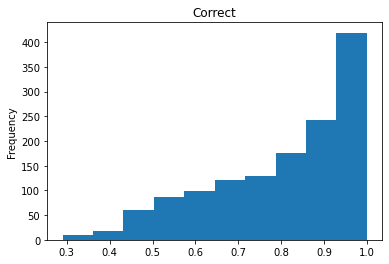

In [11]:
correct["max_probability"].plot.hist(title="Correct")

In [12]:
len(correct)

1361

<AxesSubplot:title={'center':'Wrong'}, ylabel='Frequency'>

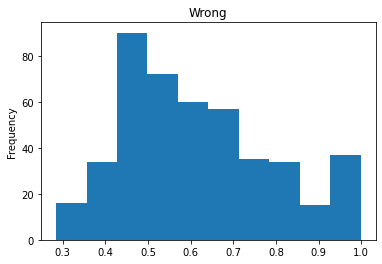

In [13]:
wrong["max_probability"].plot.hist(title="Wrong")

In [14]:
len(wrong)

450

In [15]:
high = er[er["max_probability"] > 0.8]
len(high)

895

In [16]:
print(classification_report(high["actual"], high["predicted"]))

              precision    recall  f1-score   support

         APT       0.90      0.75      0.82        12
        Core       0.94      0.89      0.92       264
       Debug       0.94      0.99      0.96       202
         Doc       1.00      0.67      0.80         3
        Text       0.78      0.75      0.77        72
          UI       0.90      0.92      0.91       342

    accuracy                           0.91       895
   macro avg       0.91      0.83      0.86       895
weighted avg       0.91      0.91      0.91       895



In [17]:
print(classification_report(er["actual"], er["predicted"]))

              precision    recall  f1-score   support

         APT       0.90      0.56      0.69        16
        Core       0.76      0.77      0.76       546
       Debug       0.90      0.78      0.84       302
         Doc       1.00      0.25      0.40        12
        Text       0.64      0.51      0.57       236
          UI       0.72      0.82      0.77       699

    accuracy                           0.75      1811
   macro avg       0.82      0.62      0.67      1811
weighted avg       0.75      0.75      0.75      1811



## 2. **Measuring Feature Importance of Predictive Models**

In [18]:
svc.coef_

<15x6403 sparse matrix of type '<class 'numpy.float64'>'
	with 64451 stored elements in Compressed Sparse Row format>

In [19]:
# coef_[8] yields a matrix, A[0] converts to array and takes first row

coef = svc.coef_[8].A[0]
vocabulary_positions = coef.argsort()
vocabulary = tfidf.get_feature_names()

In [27]:
top_words = 10
top_positive_coef = vocabulary_positions[-top_words:].tolist()
top_negative_coef = vocabulary_positions[:top_words].tolist()

In [28]:
core_ui = pd.DataFrame([[vocabulary[c],
                  coef[c]] for c in top_positive_coef + top_negative_coef],
                  columns=['feature', 'coefficient']).sort_values("coefficient")

<AxesSubplot:ylabel='feature'>

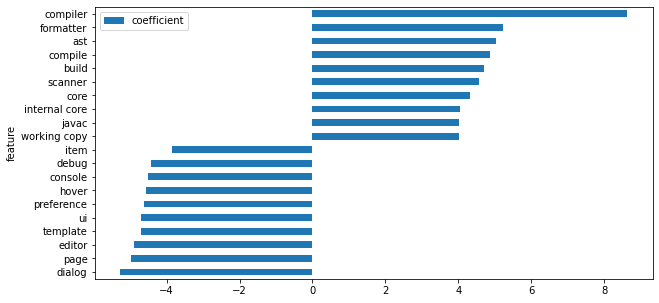

In [29]:
core_ui.set_index("feature").plot.barh(figsize=(10, 5))

In [30]:
c = svc.coef_
coef = (c[5] + c[6] + c[7] + c[8] - c[0]).A[0]
vocabulary_positions = coef.argsort()

<AxesSubplot:ylabel='feature'>

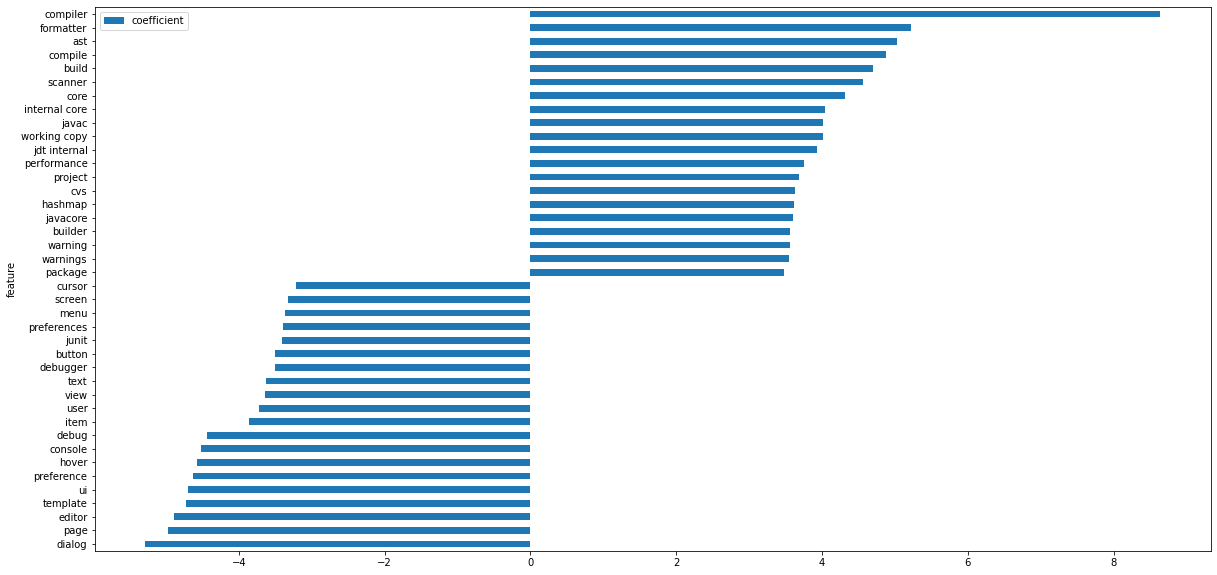

In [31]:
top_words = 20
top_positive_coef = vocabulary_positions[-top_words:].tolist()
top_negative_coef = vocabulary_positions[:top_words].tolist()
core = pd.DataFrame([[vocabulary[c], coef[c]] for c in top_positive_coef + top_negative_coef], 
                       columns=["feature", "coefficient"]).sort_values("coefficient")
core.set_index("feature").plot.barh(figsize=(20, 10))

## 3. **Using LIME to Explain the Classification Results**

In [34]:
pipeline = make_pipeline(tfidf, svc)
pipeline.predict_proba(['compiler not working'])

array([[0.00240522, 0.95605684, 0.00440957, 0.00100242, 0.00971824,
        0.02640771]])

In [39]:
explainer = LimeTextExplainer(class_names=class_names)
er[er['predicted']!= er['actual']].head()

index                                               text actual predicted  \
2       2  NPE in Delta processor while executing JDT/UI ...   Core        UI   
15     15  Inserting a block of text in editor badly alig...     UI      Text   
16     16  Differences when debugging identical objects W...  Debug      Core   
20     20  Foreach template doesnt work for class members...   Core        UI   
21     21  exchange left and right operands for compariso...     UI      Core   

         APT      Core     Debug       Doc      Text        UI  \
2   0.003357  0.309548  0.046491  0.002031  0.012309  0.626265   
15  0.001576  0.063076  0.034610  0.003907  0.614473  0.282356   
16  0.002677  0.430862  0.313465  0.004193  0.055838  0.192965   
20  0.000880  0.044018  0.001019  0.000783  0.130766  0.822535   
21  0.002669  0.467366  0.077252  0.003194  0.068749  0.380770   

    max_probability  
2          0.626265  
15         0.614473  
16         0.430862  
20         0.822535  
21         0.467366

In [44]:
id = 21
print(f"Document id: {id}")
print(f"Predicted Class = {er.iloc[id]['predicted']}")
print(f"True Class = {er.iloc[id]['actual']}")

Document id: 21
Predicted Class = Core
True Class = UI


In [45]:
exp = explainer.explain_instance(result.iloc[id]['text'],
                                 pipeline.predict_proba,
                                 num_features=10,
                                 labels=[1,5])
print(f"Explanation for class {class_names[1]}")
print('\n'.join(map(str, exp.as_list(label=1))))
print()
print(f"Explanation for class {class_names[5]}")
print('\n'.join(map(str, exp.as_list(label=5))))

Explanation for class Core
('Bug', 0.143822658362022)
('fix', -0.14333381480508)
('following', 0.10807442953914306)
('comparison', 0.09779307988075196)
('Fix', -0.08959148948138453)
('right', 0.0852067377372339)
('semantics', 0.08328122466937478)
('changes', -0.08037401673378605)
('left', 0.03385680417891305)
('The', 0.0030220640926468673)

Explanation for class UI
('Bug', -0.15405474811746836)
('fix', 0.15147812338556355)
('right', 0.11033352861161884)
('comparison', -0.10655312427218146)
('left', -0.10611550358205141)
('following', -0.09900242322023631)
('semantics', -0.058994874889760705)
('Fix', 0.05721201915992891)
('good', 0.04087027163375662)
('changes', 0.038626832144274294)


In [47]:
exp = explainer.explain_instance(result.iloc[id]["text"], pipeline.predict_proba, num_features=6, top_labels=3)
exp.show_in_notebook(text=False)

In [52]:
import numpy as np
np.random.seed(42)
lsm = submodular_pick.SubmodularPick(explainer, er['text'].values,
                                     pipeline.predict_proba,
                                     sample_size=100,
                                     num_features=20,
                                     num_exps_desired=5)
lsm.explanations[0].show_in_notebook()


## 4. **Using ELI5 to Explain the Classification Results**

In [54]:
svm = SGDClassifier(loss='hinge', max_iter=1000, tol=1e-3, random_state=42)
svm.fit(X_train_tf, Y_train)
Y_pred_svm = svm.predict(X_test_tf)
print(classification_report(Y_test, Y_pred_svm))


              precision    recall  f1-score   support

         APT       0.89      0.50      0.64        16
        Core       0.77      0.78      0.77       546
       Debug       0.85      0.84      0.85       302
         Doc       0.75      0.25      0.38        12
        Text       0.62      0.59      0.60       236
          UI       0.76      0.79      0.78       699

    accuracy                           0.76      1811
   macro avg       0.77      0.62      0.67      1811
weighted avg       0.76      0.76      0.76      1811



In [57]:
eli5.show_weights(svm, top=10, vec=tfidf, target_names=class_names)

In [58]:
eli5.show_prediction(svm, X_test.iloc[21],  vec=tfidf, target_names=class_names)

## 5. **Using Anchor to Explain the Classification Results**

In [79]:
import spacy
import time


In [85]:
!pip install alibi

     |████████████████████████████████| 228 kB 1.3 MB/s eta 0:00:01
  Using cached slicer-0.0.3-py3-none-any.whl (11 kB)
  Using cached numpy-1.18.5-cp38-cp38-macosx_10_9_x86_64.whl (15.1 MB)
     |████████████████████████████████| 93.8 MB 311 kB/s eta 0:00:01
  Created wheel for spacy-lookups-data: filename=spacy_lookups_data-0.3.2-py2.py3-none-any.whl size=93807573 sha256=9d45fefaa02c5f566ceb84e741326109ac55df6f0468a7e53c069ad3a7ef05f1
  Stored in directory: /Users/damienmellot/Library/Caches/pip/wheels/14/41/9b/5215f783f67bd1f98c76e8a2a95fdbfd7bf37fac0500af0987
Successfully built spacy-lookups-data
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.2
    Uninstalling numpy-1.19.2:
      Successfully uninstalled numpy-1.19.2
  Attempting uninstall: slicer
    Found existing installation: slicer 0.0.7
    Uninstalling slicer-0.0.7:
      Successfully uninstalled slicer-0.0.7


In [95]:
nlp = spacy.load('en_core_web_lg')
from alibi.explainers import anchor_text


In [96]:
np.random.seed(42)
explainer_unk = anchor_text.AnchorText(nlp, class_names)

TypeError: 'list' object is not callable